# WSPRd Grape Doppler Spectrogram
Nathaniel Frissell W2NAF - 28 Dec 2023

This Jupyter notebook will take a WAV file of HF Doppler observations created by WSPRd and generate a time domain time series and a frequency domain spectrogram.

`grape.wav` was provided by Rob Robinett AI6VN on 26 December 2023. The signal processing chain for this file is: RX888 == 64.8 Msps => KA9Q-radio -> continuous series of one minute long 16,000 sps  IQ wsv files => 240 of those wv files processed by sox into one 240 minute 10 sps IQ wav file.

## Load Libraries and Set Plotting Defaults

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import signal
from scipy.io import wavfile

%matplotlib inline

In [2]:
# Matplotlib settings to make the plots look a little nicer.

plt.rcParams['font.size']      = 18
plt.rcParams['font.weight']    = 'bold'
plt.rcParams['axes.grid']      = True
plt.rcParams['axes.xmargin']   = 0
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['figure.figsize'] = (10,6)

## Define Custom Functions

In [3]:
def plot_cxSig(t,xx,xlim=None,ylim=None,flim=None,title=None,xunit='s'):
    """
    Plot the time domain and spectrogram of a signal.
    t:  Time Vector in seconds.
    xx: time-domain signal
    
    xlim: (x0, x1) Limits of x-axis (in seconds) for both time series and spectrograms.
    ylim: (y0, y1) Limits of time series plot y-axis.
    flim: (f0, f1) Limits of spectrogram plot y-axis.
    
    title: Title for entire plot.
    
    xunit: Time unit for plotting x-axis. The input time vector (in seconds) will be converted to the new unit.
        's': Seconds
        'min': minutes
        'hr': hours
    """
    
    # Compute the Sample Rate
    fs = 1/(t[1]-t[0])

    f, t_spec, Sxx = signal.spectrogram(xx,fs=fs,window='hann',return_onesided=False)
    f    = np.fft.fftshift(f)
    Sxx  = np.fft.fftshift(Sxx,axes=0)
    Sxx_db = 10*np.log10(Sxx)

    if xunit == 's':
        tt      = t
        tt_spec = t_spec
        xlabel  = 't [s]'
    elif xunit == 'min':
        tt      = t/60.
        tt_spec = t_spec/60.
        xlabel  = 't [min]'
    elif xunit == 'hr':
        tt      = t/3600.
        tt_spec = t_spec/3600.
        xlabel  = 't [hr]'
    
    fig = plt.figure(figsize=(15,7))

    ax0  = fig.add_subplot(2,1,1)
    ax0.plot(tt,np.real(xx),label='Real')
    ax0.plot(tt,np.imag(xx),label='Imag')
    ax0.set_xlabel(xlabel)
    ax0.set_ylabel('Amplitude')
    ax0.set_xlim(xlim)
    ax0.set_ylim(ylim)
    ax0.legend(loc='upper right',fontsize='small')

    ax1  = fig.add_subplot(2,1,2)
    mpbl = ax1.pcolormesh(tt_spec,f,Sxx_db)
    cbar = fig.colorbar(mpbl,label='PSD [dB]')
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel('f [Hz]')
    ax1.set_xlim(xlim)
    ax1.set_ylim(flim)
    
    if title is not None:
        ax0.set_title(title)

    fig.tight_layout()

    # The next three lines make sure the time-domain plot lines up properly with the spectrogram.
    ax0p = ax0.get_position().bounds
    ax1p = ax1.get_position().bounds
    ax0.set_position((ax0p[0],ax0p[1],ax1p[2],ax0p[3]))

    plt.show()

In [4]:
# Load in the file and detect the sampling frequency
fname1        = 'grape.wav'
fs_wav1, wav1 = wavfile.read(fname1)

# Convert data from 2 columns to a single vector of complex data
wav1 = wav1[:,0] + 1j*wav1[:,1]

# Calculate a time vector in seconds
duration      = len(wav1) * 1/fs_wav1
t_wav1        = np.arange(len(wav1))*(1/fs_wav1) 

In [5]:
# Print out the wav1 vector
wav1

array([-1255.-2648.j, -4416.-3516.j, -5026.-1199.j, ...,   302.-3988.j,
       -2652. -167.j,  1392.+2813.j])

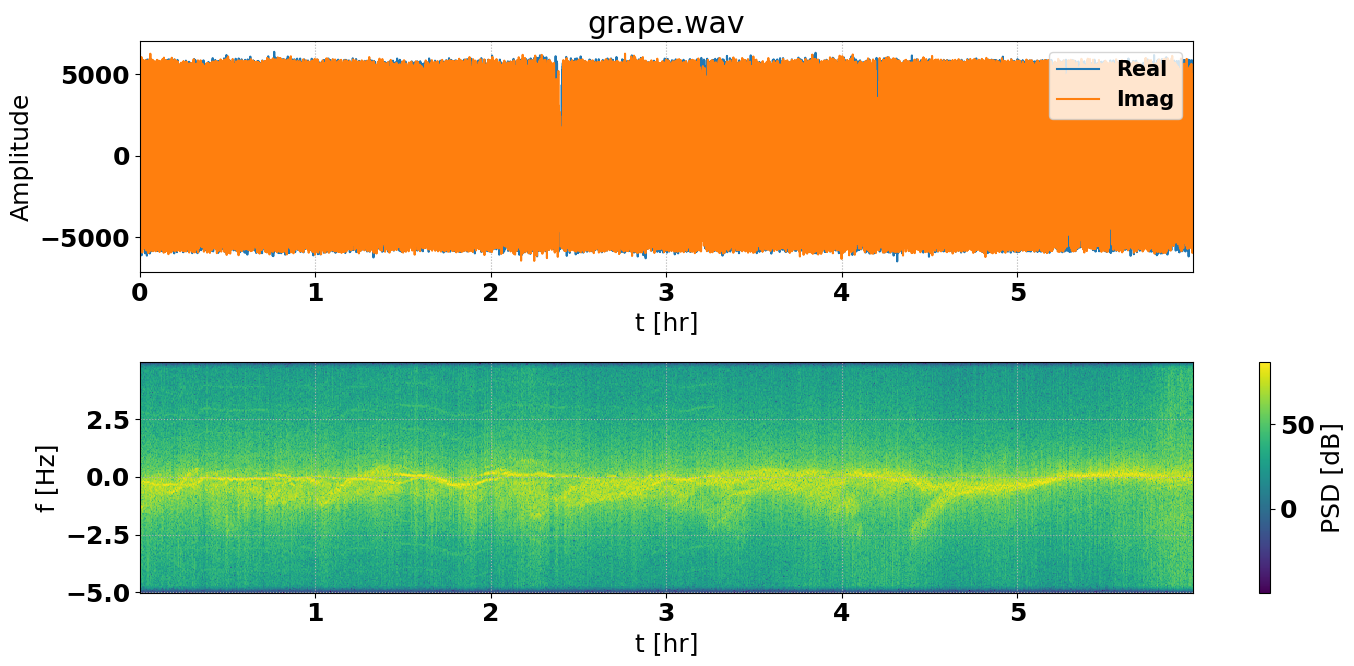

In [6]:
# Plot the signal and spectrogram.
plot_cxSig(t_wav1,wav1,title=fname1,xunit='hr')